# CSIRO Image2Biomass: Comprehensive EDA & Image Explorer

**Competition:** [CSIRO Image2Biomass Prediction](https://www.kaggle.com/competitions/csiro-biomass)

**Thank you CigarCat!** [NB link](https://www.kaggle.com/code/takahitomizunobyts/csiro-customizable-eda)

---

## **Notebook Overview**

This notebook provides a **complete exploratory data analysis** for the CSIRO Image2Biomass competition, with a special focus on understanding the relationship between images and their corresponding biomass measurements.
Also the next steps!

### **Competition Context:**

**Goal:** Predict 5 biomass components from pasture images:
- `Dry_Green_g` (10% weight)
- `Dry_Dead_g` (10% weight)
- `Dry_Clover_g` (10% weight)
- `GDM_g` (20% weight)
- `Dry_Total_g` (50% weight) ⭐

**Evaluation:** Weighted R² score

**REM**: clover = gdm - green and dead = total - gdm

So we need to predict three components, namely:
- GDM - Green Dry Matter
- Total
- Green

## Setup & Configuration

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Configuration
CSV_PATH_TRAIN = "../csiro-biomass/train.csv"
CSV_PATH_TEST = "../csiro-biomass/test.csv"
IMAGE_DIR = "../csiro-biomass"

# Target columns
TARGET_COLS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

# Competition weights
WEIGHTS = {
    'Dry_Green_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Clover_g': 0.1,
    'GDM_g': 0.2,
    'Dry_Total_g': 0.5
}

# Random seed for reproducibility
RANDOM_SEED = 42

print("Configuration set!")

Configuration set!


## Data Loading & Preprocessing

### What we'll do:
1. Load the CSV data (long format: 5 rows per image)
2. Convert to wide format (1 row per image)
3. Add temporal features (season, year, month)
4. Add derived features (ratios, physical constraints)

In [3]:
def load_and_preprocess_data(csv_path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and preprocess biomass data
    
    Returns:
        Tuple of (long_format_df, wide_format_df)
    """
    # Load data
    print("Loading data...")
    df_long = pd.read_csv(csv_path)
    print(f"Loaded {len(df_long):,} rows × {len(df_long.columns)} columns")
    
    # Extract image ID
    df_long['image_id'] = df_long['sample_id'].str.split('__').str[0]
    
    # Convert to wide format
    print("\nConverting to wide format...")
    meta_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 
                 'Pre_GSHH_NDVI', 'Height_Ave_cm']
    
    df_wide = df_long.pivot_table(
        index=['image_id'] + meta_cols,
        columns='target_name',
        values='target',
        aggfunc='first'
    ).reset_index()
    
    n_images = len(df_wide)
    print(f"Wide format: {n_images:,} images")
    
    # Add temporal features
    print("\nAdding temporal features...")
    df_wide['date'] = pd.to_datetime(df_wide['Sampling_Date'], format='%Y/%m/%d')
    df_wide['year'] = df_wide['date'].dt.year
    df_wide['month'] = df_wide['date'].dt.month
    df_wide['day'] = df_wide['date'].dt.day
    df_wide['dayofweek'] = df_wide['date'].dt.dayofweek
    df_wide['dayofyear'] = df_wide['date'].dt.dayofyear
    
    # Add season (Southern Hemisphere)
    def get_season(month: int) -> str:
        if month in [9, 10, 11]:
            return "Spring"
        elif month in [12, 1, 2]:
            return "Summer"
        elif month in [3, 4, 5]:
            return "Autumn"
        else:
            return "Winter"
    
    df_wide['season'] = df_wide['month'].apply(get_season)
    
    # Add derived features
    print("Adding derived features...")
    
    # Component ratios
    total = df_wide['Dry_Total_g'] + 1e-8 # Avoid division by 0
    df_wide['green_ratio'] = df_wide['Dry_Green_g'] / total
    df_wide['dead_ratio'] = df_wide['Dry_Dead_g'] / total
    df_wide['clover_ratio'] = df_wide['Dry_Clover_g'] / total
    
    # Physical constraint check
    df_wide['sum_components'] = (
        df_wide['Dry_Green_g'] + 
        df_wide['Dry_Dead_g'] + 
        df_wide['Dry_Clover_g']
    )
    df_wide['constraint_diff'] = df_wide['Dry_Total_g'] - df_wide['sum_components']
    df_wide['constraint_error'] = np.abs(df_wide['constraint_diff'])
    
    print("Preprocessing complete!\n")
    
    return df_long, df_wide

# Execute
df_long, df = load_and_preprocess_data(CSV_PATH_TRAIN)

Loading data...
Loaded 1,785 rows × 9 columns

Converting to wide format...
Wide format: 357 images

Adding temporal features...
Adding derived features...
Preprocessing complete!



In [4]:
df_long.head()
df_long.shape

(1785, 10)

In [5]:
# Quick peek at the data
print("="*80)
print("DATA OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nDate range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Number of states: {df['State'].nunique()}")
print(f"Number of species combinations: {df['Species'].nunique()}")
print(f"Number of images: {df['image_id'].nunique():,}")
print(f"Image dimensions: {Image.open(Path(IMAGE_DIR) / df['image_path'].iloc[0]).size}")

DATA OVERVIEW

Shape: 357 rows × 25 columns
Memory: 0.18 MB

Date range: 2015-01-15 to 2015-11-10
Number of states: 4
Number of species combinations: 15
Number of images: 357
Image dimensions: (2000, 1000)


In [6]:
df_long.head()

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,image_id
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.67,Dry_Clover_g,0.00,ID1011485656
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.67,Dry_Dead_g,32.00,ID1011485656
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.67,Dry_Green_g,16.28,ID1011485656
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.67,Dry_Total_g,48.27,ID1011485656
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.67,GDM_g,16.27,ID1011485656


In [7]:
# Display first few rows
df.head()

target_name,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,date,year,month,day,dayofweek,dayofyear,season,green_ratio,dead_ratio,clover_ratio,sum_components,constraint_diff,constraint_error
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.67,0.00,32.00,16.28,48.27,16.27,2015-09-04,2015,9,4,4,247,Spring,0.34,0.66,0.00,48.27,0.00,0.00
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.00,0.00,0.00,7.60,7.60,7.60,2015-04-01,2015,4,1,2,91,Autumn,1.00,0.00,0.00,7.60,0.00,0.00
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.00,6.05,0.00,0.00,6.05,6.05,2015-09-01,2015,9,1,1,244,Spring,0.00,0.00,1.00,6.05,0.00,0.00
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.00,0.00,30.97,24.24,55.21,24.24,2015-05-18,2015,5,18,0,138,Autumn,0.44,0.56,0.00,55.21,0.00,0.00
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.50,0.43,23.22,10.53,34.18,10.96,2015-09-11,2015,9,11,4,254,Spring,0.31,0.68,0.01,34.18,0.00,0.00


## Data Quality Assessment

Let's check for:
- Missing values
- Data types
- Basic statistics

In [8]:
def analyze_data_quality(df: pd.DataFrame) -> None:
    """Comprehensive data quality analysis"""
    
    print("\n" + "="*80)
    print("DATA QUALITY ANALYSIS")
    print("="*80)
    
    # Missing values
    print("\n【Missing Values】")
    missing = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Pct': (df.isnull().sum() / len(df) * 100).round(2)
    })
    missing = missing[missing['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing) == 0:
        print("No missing values!")
    else:
        print(missing)

    # Negative values (needed for transformations)
    print("\n【Negative Values】")
    negatives = pd.DataFrame({
        'Negative_Count': (df.select_dtypes(include=[np.number]) < 0).sum(),
        'Negative_Pct': ((df.select_dtypes(include=[np.number]) < 0).sum() / len(df) * 100).round(2)
    })
    negatives = negatives[negatives['Negative_Count'] > 0].sort_values('Negative_Count', ascending=False)

    if len(negatives) == 0:
        print("No negative values!")
    else:
        print(negatives)
    
    # Data types
    print("\n【Data Types】")
    print(df.dtypes.value_counts())
    
    # Duplicates
    n_duplicates = df.duplicated(subset='image_id').sum()
    print(f"\n【Duplicates】")
    print(f"Duplicate image IDs: {n_duplicates}")

analyze_data_quality(df)


DATA QUALITY ANALYSIS

【Missing Values】
No missing values!

【Negative Values】
                 Negative_Count  Negative_Pct
target_name                                  
constraint_diff              55         15.41

【Data Types】
float64           13
object             6
int32              5
datetime64[ns]     1
Name: count, dtype: int64

【Duplicates】
Duplicate image IDs: 0


## Key Questions:
- What are the distributions of each target?
- Are they normally distributed?
- What are the correlations between targets?
- Are there any outliers?

In [9]:
def analyze_target_statistics(df: pd.DataFrame, target_cols: list) -> pd.DataFrame:
    """Compute comprehensive target statistics"""
    
    print("\n" + "="*80)
    print("TARGET VARIABLE STATISTICS")
    print("="*80)
    
    stats = df[target_cols].describe().T # Basic statistics
    
    # Additional metrics
    stats['cv'] = stats['std'] / stats['mean']  # Coefficient of variation - how spread out the data is compared to its average
    stats['skewness'] = df[target_cols].skew() # Measure of asymmetry of the distribution
    stats['kurtosis'] = df[target_cols].kurtosis() # Measure of the "tailedness" of the distribution - how heavy or light the tails are compared to a normal distribution
    stats['comp_weight'] = [WEIGHTS[col] for col in target_cols] # Competition weights
    
    return stats.round(3)

target_stats = analyze_target_statistics(df, TARGET_COLS)
target_stats


TARGET VARIABLE STATISTICS


,count,mean,std,min,25%,50%,75%,max,cv,skewness,kurtosis,comp_weight
target_name,,,,,,,,,,,,
Dry_Green_g,357.00,26.62,25.40,0.00,8.80,20.80,35.08,157.98,0.95,1.75,3.91,0.10
Dry_Dead_g,357.00,12.04,12.40,0.00,3.20,7.98,17.64,83.84,1.03,1.76,4.20,0.10
Dry_Clover_g,357.00,6.65,12.12,0.00,0.00,1.42,7.24,71.79,1.82,2.84,9.07,0.10
GDM_g,357.00,33.27,24.94,1.04,16.03,27.11,43.68,157.98,0.75,1.56,3.05,0.20
Dry_Total_g,357.00,45.32,27.98,1.04,25.27,40.30,57.88,185.70,0.62,1.43,3.08,0.50


In [10]:
# Interpretation
print("\nKey Observations:")
print(f"• Dry_Total_g has the highest mean ({target_stats.loc['Dry_Total_g', 'mean']:.1f}g) " +
      "and is the primary target (50% weight - median)")
print(f"• Dry_Clover_g has high variability (CV: {target_stats.loc['Dry_Clover_g', 'cv']:.2f}) - meaning that its values are widely spread out from the mean")
print(f"• All targets show positive skewness (right-tailed distributions) - indicating that there are more low values and a few extreme high values")


Key Observations:
• Dry_Total_g has the highest mean (45.3g) and is the primary target (50% weight - median)
• Dry_Clover_g has high variability (CV: 1.82) - meaning that its values are widely spread out from the mean
• All targets show positive skewness (right-tailed distributions) - indicating that there are more low values and a few extreme high values


## Target Distribution Visualization

Let's visualize the distributions with:
- Histograms (with mean/median lines)
- Box plots (for outlier detection)
- Q-Q plots (for normality check)

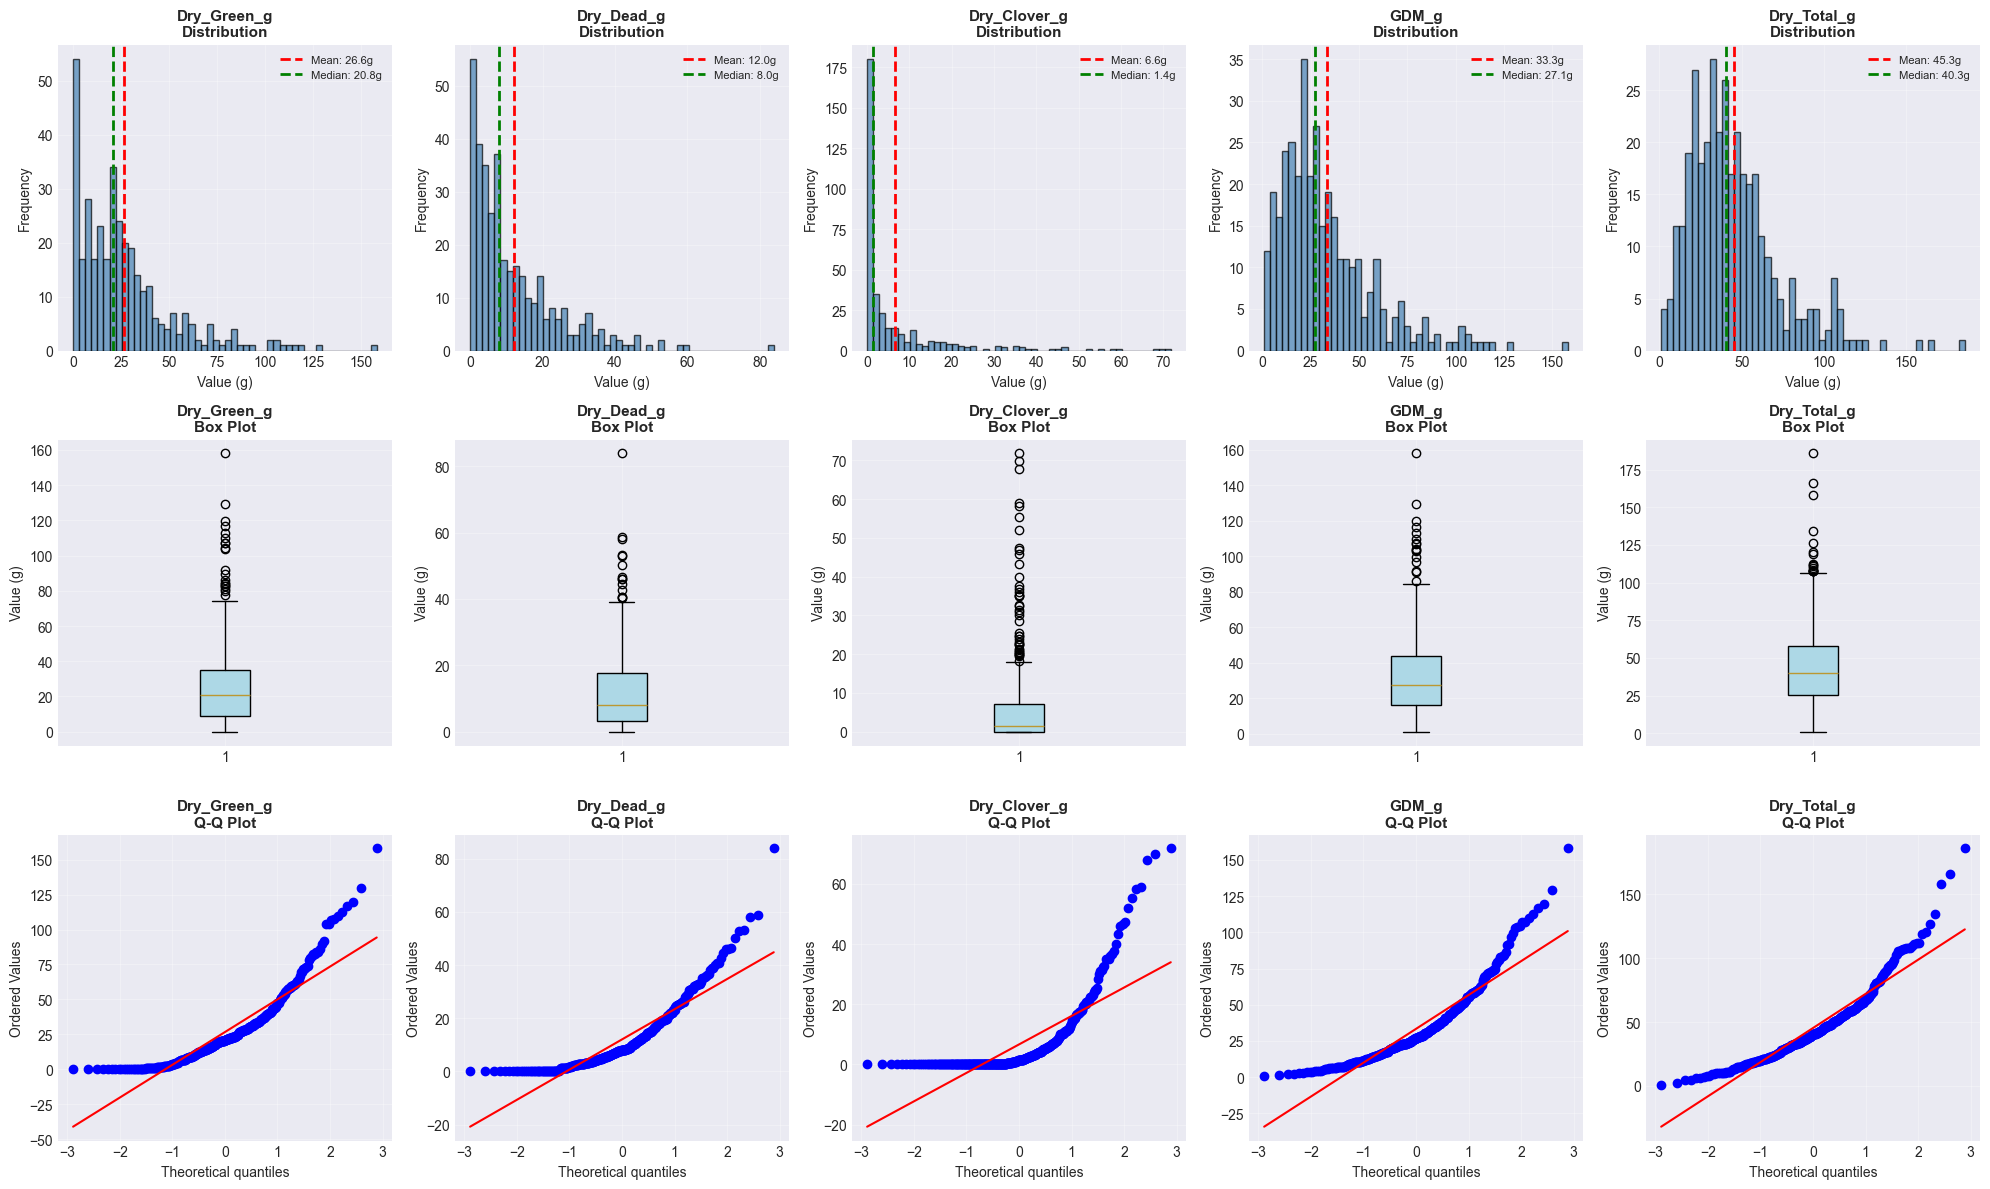

In [11]:
def plot_target_distributions(df: pd.DataFrame, target_cols: list) -> None:
    """Plot comprehensive target distributions"""
    
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    
    for i, target in enumerate(target_cols):
        data = df[target].dropna()
        
        # Histogram
        axes[0, i].hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[0, i].axvline(data.mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {data.mean():.1f}g')
        axes[0, i].axvline(data.median(), color='green', linestyle='--', 
                          linewidth=2, label=f'Median: {data.median():.1f}g')
        axes[0, i].set_title(f'{target}\nDistribution', fontsize=11, fontweight='bold')
        axes[0, i].set_xlabel('Value (g)')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].legend(fontsize=8)
        axes[0, i].grid(True, alpha=0.3)
        
        # Box plot
        bp = axes[1, i].boxplot(data, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        axes[1, i].set_title(f'{target}\nBox Plot', fontsize=11, fontweight='bold')
        axes[1, i].set_ylabel('Value (g)')
        axes[1, i].grid(True, alpha=0.3)
        
        # Q-Q plot
        stats.probplot(data, dist="norm", plot=axes[2, i])
        axes[2, i].set_title(f'{target}\nQ-Q Plot', fontsize=11, fontweight='bold')
        axes[2, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_target_distributions(df, TARGET_COLS)

Distribution Insights:
- All targets show right-skewed distributions (more low values than high)
- Q-Q plots show deviations from normality, especially at the tails
- Consider log transformation for modeling
- Several outliers present in all targets - visible from box plots and high kurtosis (3.91)

## Correlation Analysis

Understanding relationships between targets is crucial for:
- Multi-task learning strategies
- Feature engineering
- Model architecture design

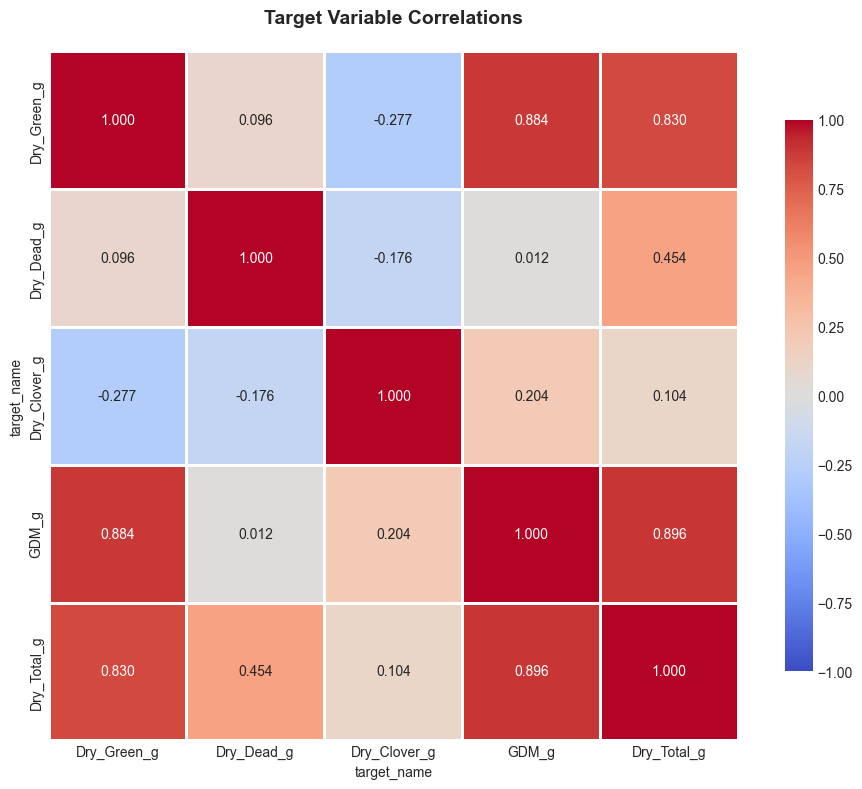


Key Correlations:

Strongest positive correlations:
  • GDM_g ↔ Dry_Total_g: 0.896
  • Dry_Green_g ↔ GDM_g: 0.884
  • Dry_Green_g ↔ Dry_Total_g: 0.830

Weakest correlations:
  • Dry_Dead_g ↔ GDM_g: 0.012
  • Dry_Dead_g ↔ Dry_Clover_g: -0.176
  • Dry_Green_g ↔ Dry_Clover_g: -0.277


In [12]:
def plot_correlation_analysis(df: pd.DataFrame, target_cols: list) -> None:
    """Plot correlation heatmap and key insights"""
    
    corr = df[target_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', 
               center=0, square=True, linewidths=2,
               cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
    plt.title('Target Variable Correlations', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print key correlations
    print("\nKey Correlations:")
    
    # Get upper triangle
    corr_flat = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    corr_pairs = corr_flat.stack().sort_values(ascending=False)
    
    print("\nStrongest positive correlations:")
    for (var1, var2), corr_val in corr_pairs.head(3).items():
        print(f"  • {var1} ↔ {var2}: {corr_val:.3f}")
    
    print("\nWeakest correlations:")
    for (var1, var2), corr_val in corr_pairs.tail(3).items():
        print(f"  • {var1} ↔ {var2}: {corr_val:.3f}")

plot_correlation_analysis(df, TARGET_COLS)

Dry_Green_g is the key value for total biomass, as:
- GDM_g ↔ Dry_Total_g (0.896): These two measures are tightly linked — as general dry matter increases, total dry biomass does too.
 - Dry_Green_g ↔ GDM_g (0.884): Green biomass is a major contributor to green dry matter.
 - Dry_Green_g ↔ Dry_Total_g (0.830): Green biomass strongly influences total biomass.

And:
- Dry_Dead_g ↔ GDM_g (0.012): Dead biomass has almost no influence on green dry matter.
- Dry_Dead_g ↔ Dry_Clover_g (-0.176): Slight negative relationship — more dead biomass may mean less clover.
- Dry_Green_g ↔ Dry_Clover_g (-0.277): Moderate negative correlation — green biomass and clover may compete or reflect different ecological conditions.

## Metadata Exploration

Let's explore the metadata features:
- Geographic (State)
- Temporal (Season, Year)
- Physical (NDVI, Height)
- Biological (Species)

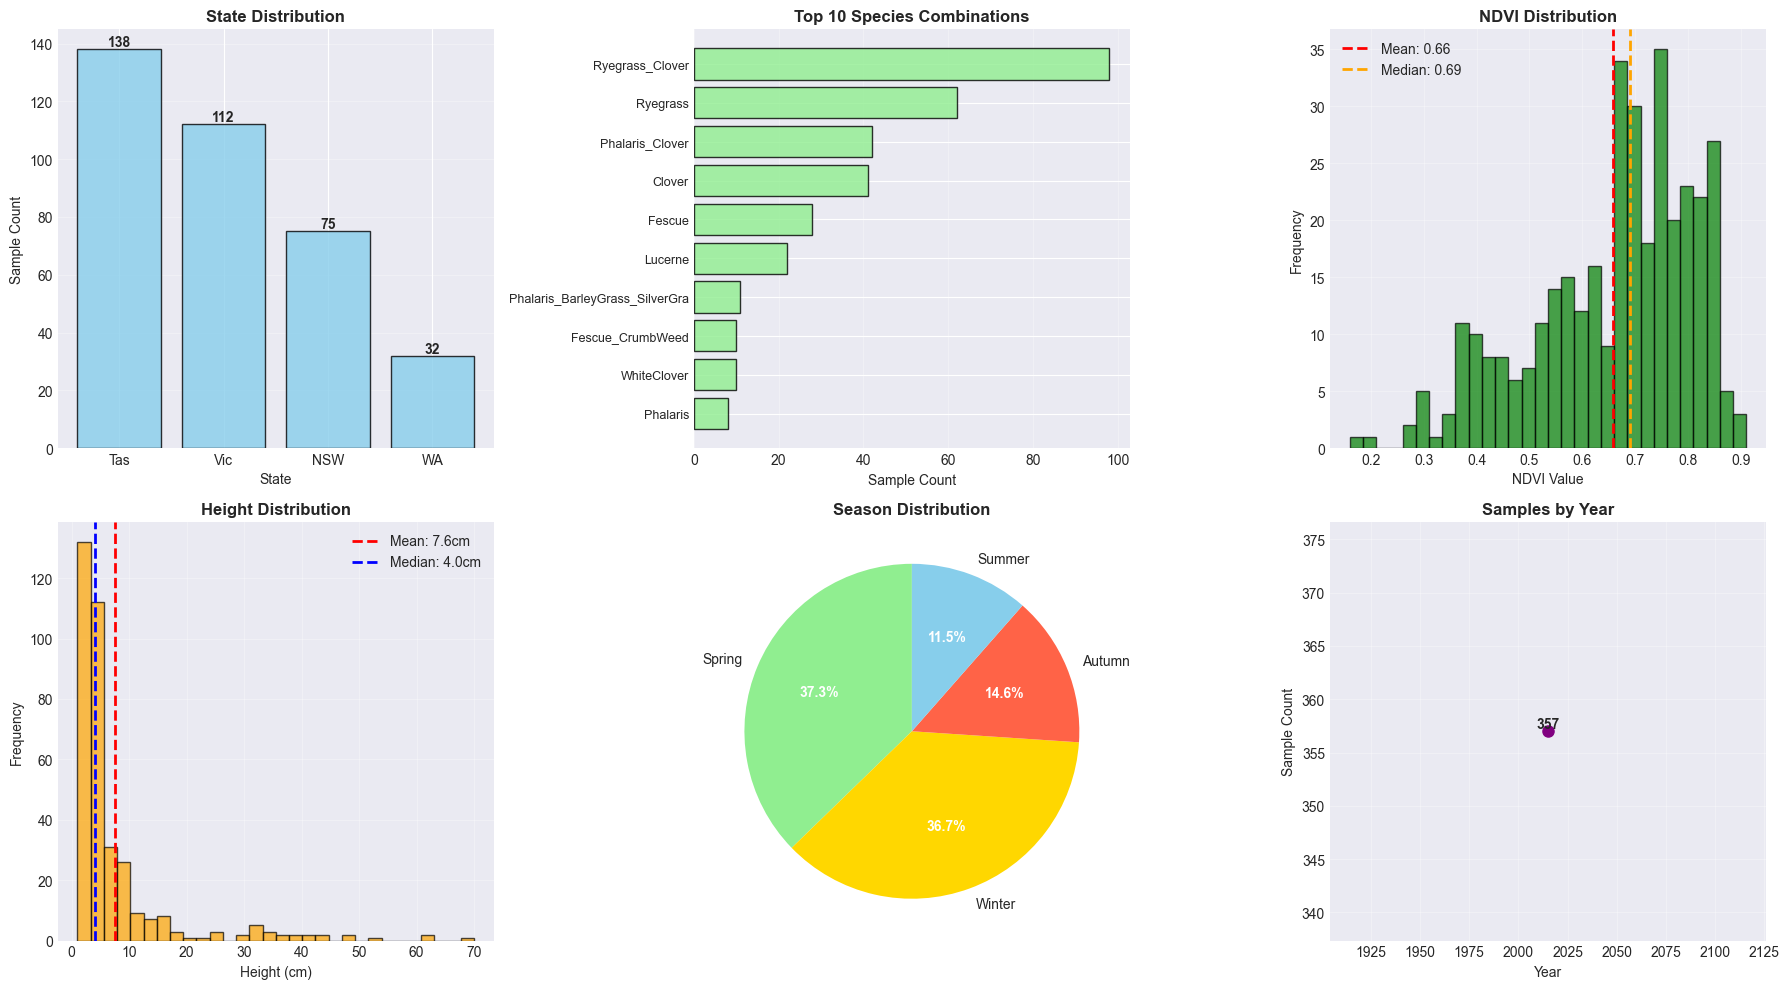

In [13]:
def plot_metadata_distributions(df: pd.DataFrame) -> None:
    """Plot metadata feature distributions"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # State distribution
    state_counts = df['State'].value_counts()
    bars = axes[0].bar(state_counts.index, state_counts.values, 
                      edgecolor='black', color='skyblue', alpha=0.8)
    axes[0].set_title('State Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel('Sample Count')
    axes[0].grid(True, alpha=0.3, axis='y')
    for bar, count in zip(bars, state_counts.values):
        axes[0].text(bar.get_x() + bar.get_width()/2, count, 
                    str(count), ha='center', va='bottom', fontweight='bold')
    
    # Top 10 species
    species_counts = df['Species'].value_counts().head(10)
    axes[1].barh(range(len(species_counts)), species_counts.values, 
                edgecolor='black', color='lightgreen', alpha=0.8)
    axes[1].set_yticks(range(len(species_counts)))
    axes[1].set_yticklabels([s[:30] for s in species_counts.index], fontsize=9)
    axes[1].set_title('Top 10 Species Combinations', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Sample Count')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')
    
    # NDVI distribution
    ndvi_data = df['Pre_GSHH_NDVI'].dropna()
    axes[2].hist(ndvi_data, bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[2].axvline(ndvi_data.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {ndvi_data.mean():.2f}')
    axes[2].axvline(ndvi_data.median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {ndvi_data.median():.2f}')
    axes[2].set_title('NDVI Distribution', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('NDVI Value')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Height distribution
    height_data = df['Height_Ave_cm'].dropna()
    axes[3].hist(height_data, bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[3].axvline(height_data.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {height_data.mean():.1f}cm')
    axes[3].axvline(height_data.median(), color='blue', linestyle='--', 
                   linewidth=2, label=f'Median: {height_data.median():.1f}cm')
    axes[3].set_title('Height Distribution', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Height (cm)')
    axes[3].set_ylabel('Frequency')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    # Season distribution
    season_counts = df['season'].value_counts()
    colors = ['#90EE90', '#FFD700', '#FF6347', '#87CEEB']
    wedges, texts, autotexts = axes[4].pie(
        season_counts.values, labels=season_counts.index, 
        autopct='%1.1f%%', startangle=90, colors=colors
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    axes[4].set_title('Season Distribution', fontsize=12, fontweight='bold')
    
    # Yearly sample counts
    year_counts = df['year'].value_counts().sort_index()
    axes[5].plot(year_counts.index, year_counts.values, 
                marker='o', linewidth=2, markersize=8, color='purple')
    axes[5].set_title('Samples by Year', fontsize=12, fontweight='bold')
    axes[5].set_xlabel('Year')
    axes[5].set_ylabel('Sample Count')
    axes[5].grid(True, alpha=0.3)
    for x, y in zip(year_counts.index, year_counts.values):
        axes[5].text(x, y, str(y), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_metadata_distributions(df)

In [14]:
print("\nMetadata Insights:")
print(f"• Data collected across {df['State'].nunique()} Australian states")
print(f"• {df['Species'].nunique()} unique species combinations")
print(f"• NDVI range: {df['Pre_GSHH_NDVI'].min():.2f} to {df['Pre_GSHH_NDVI'].max():.2f}\n\t so we have dense vegetation, but some samples are sparser because of the skewness")
print(f"• Height range: {df['Height_Ave_cm'].min():.1f} to {df['Height_Ave_cm'].max():.1f} cm")
print(f"• Data spans {df['year'].nunique()} years ({df['year'].min()}-{df['year'].max()})")
print(f"• Samples from: {df['State'].value_counts()}")


Metadata Insights:
• Data collected across 4 Australian states
• 15 unique species combinations
• NDVI range: 0.16 to 0.91
	 so we have dense vegetation, but some samples are sparser because of the skewness
• Height range: 1.0 to 70.0 cm
• Data spans 1 years (2015-2015)
• Samples from: State
Tas    138
Vic    112
NSW     75
WA      32
Name: count, dtype: int64


## Target vs Metadata Relationships

Understanding how targets vary across:
- States
- Seasons
- NDVI values
- Height measurements
- Species

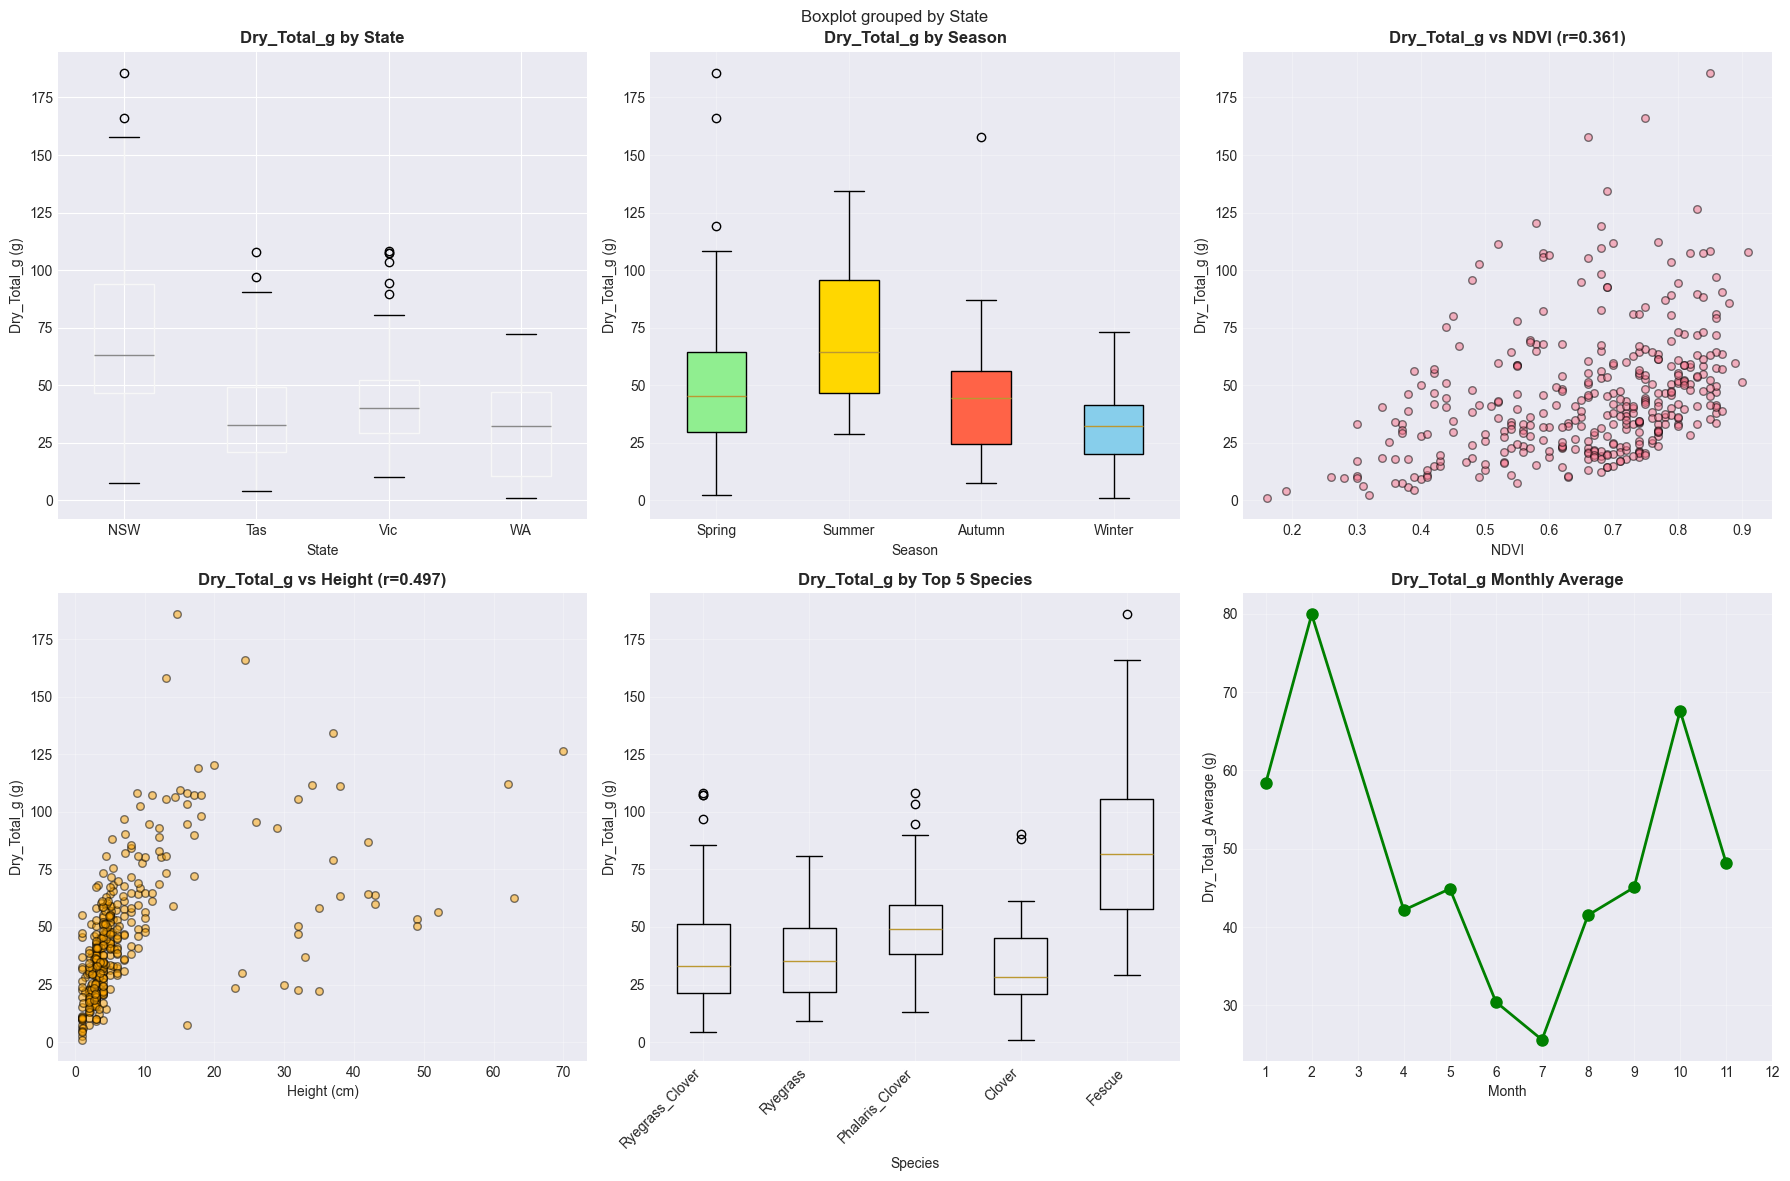


Dry_Total_g shows variation across states, seasons, and metadata


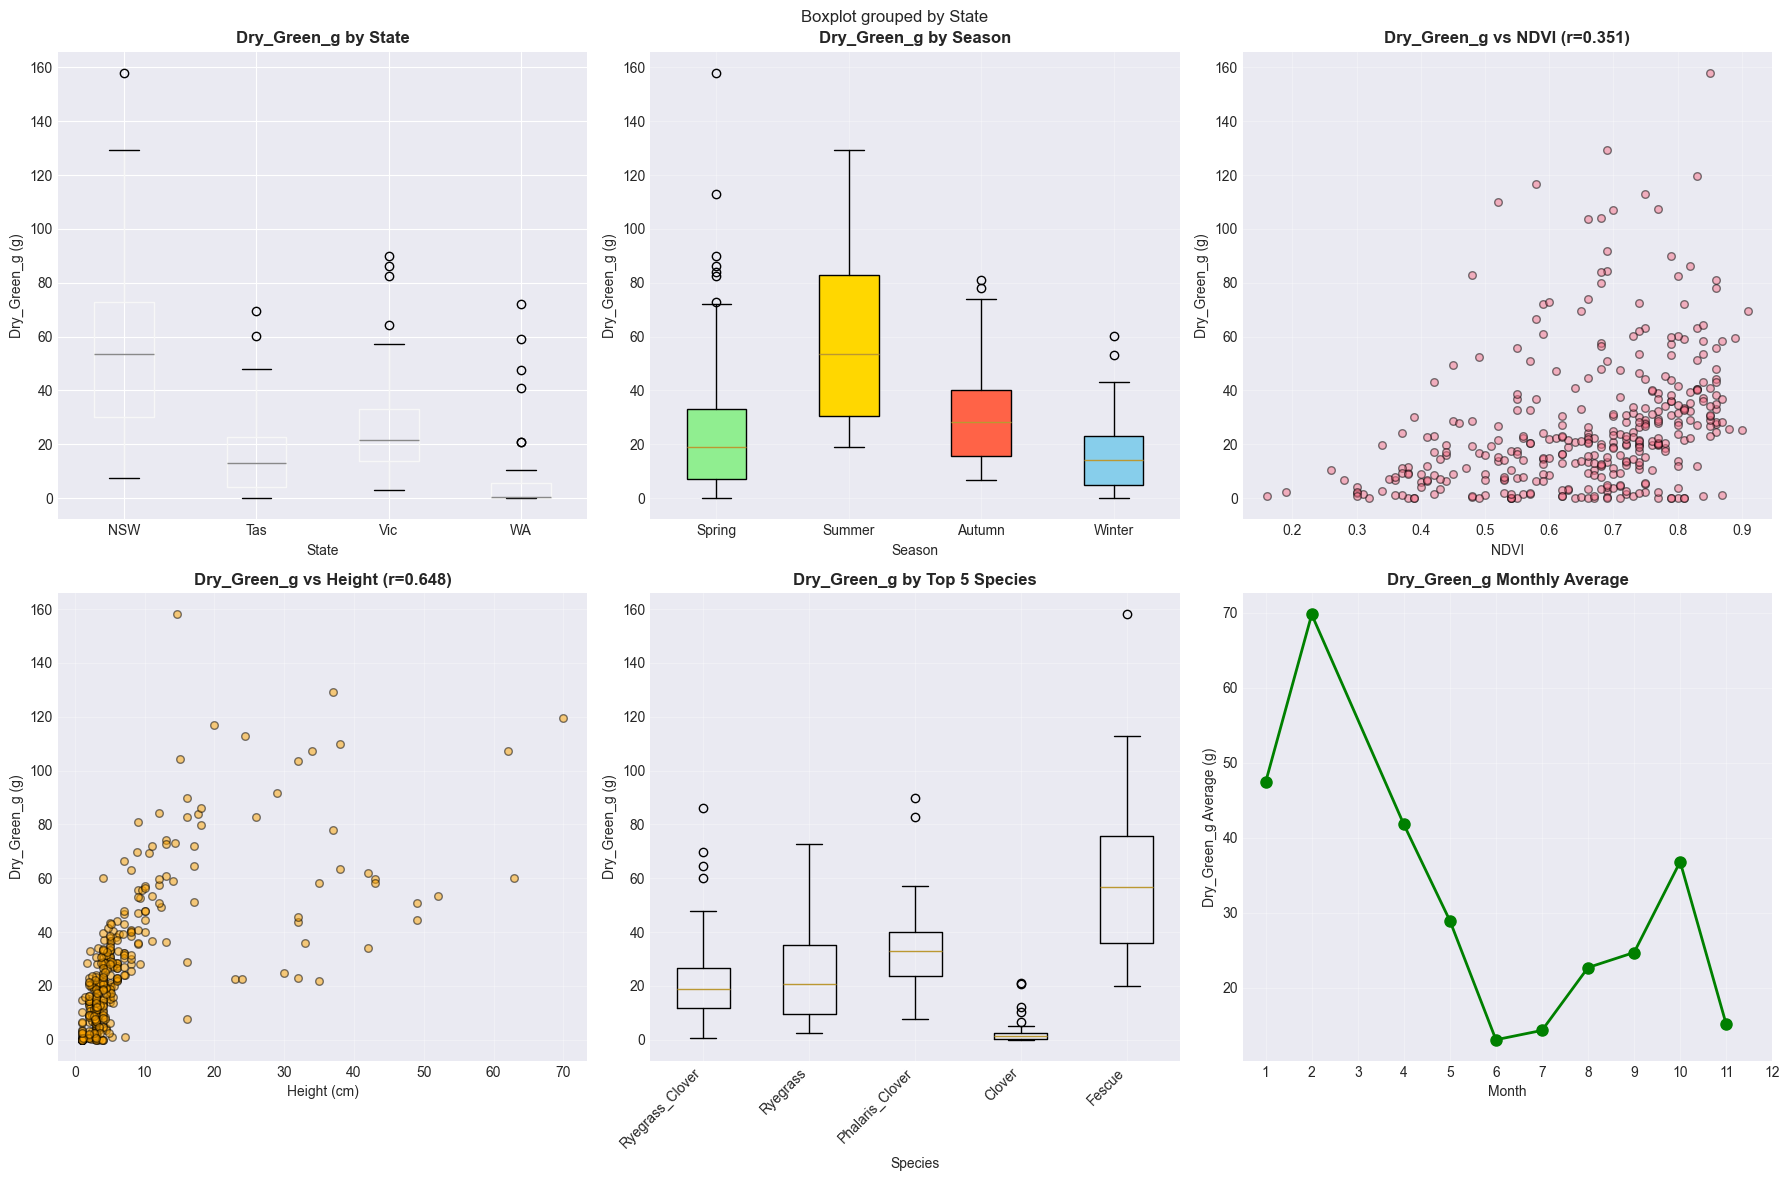


Dry_Green_g shows variation across states, seasons, and metadata


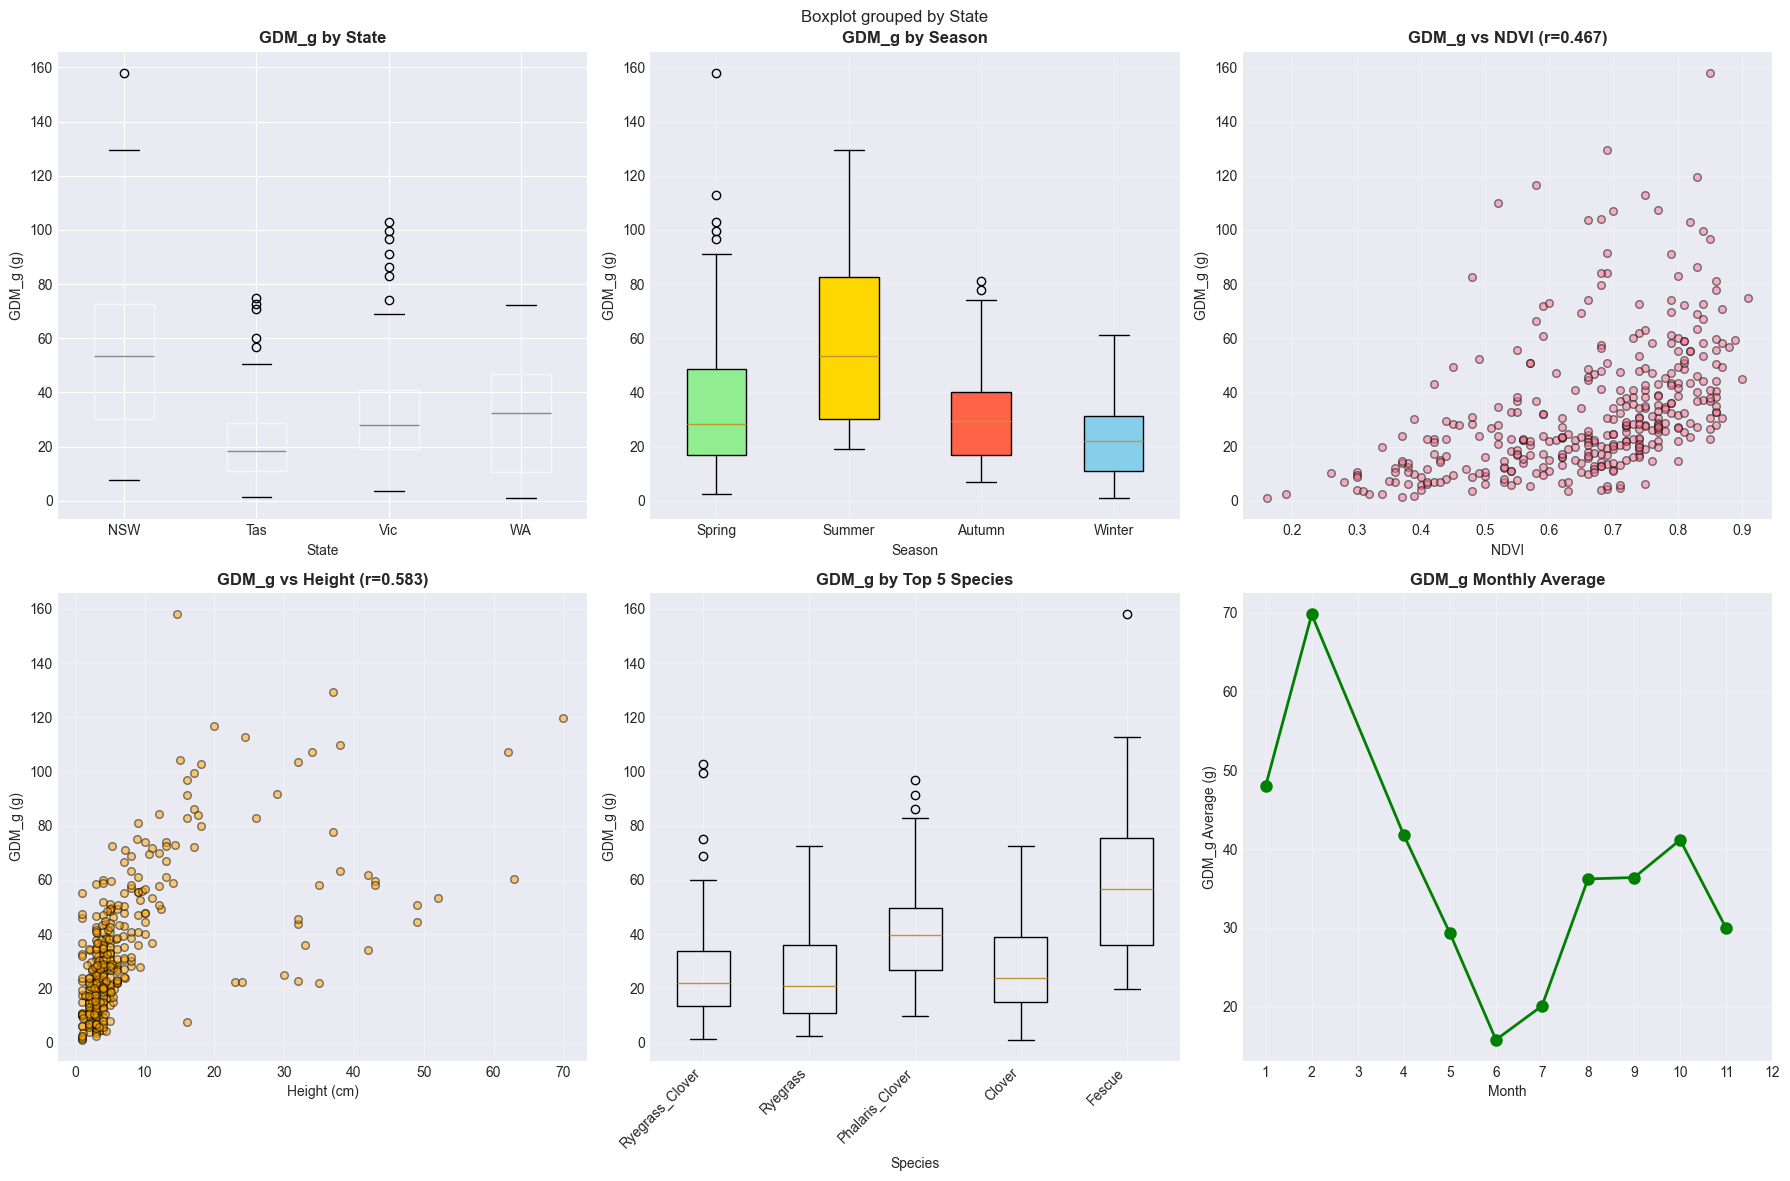


GDM_g shows variation across states, seasons, and metadata


In [15]:
def plot_target_by_metadata(df: pd.DataFrame, target: str = 'Dry_Total_g') -> None:
    """Plot target relationships with metadata"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # By State
    df.boxplot(column=target, by='State', ax=axes[0])
    axes[0].set_title(f'{target} by State', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel(f'{target} (g)')
    plt.sca(axes[0])
    plt.xticks(rotation=0)
    
    # By Season
    season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
    season_data = [df[df['season'] == s][target].dropna() for s in season_order]
    bp = axes[1].boxplot(season_data, labels=season_order, patch_artist=True)
    colors = ['#90EE90', '#FFD700', '#FF6347', '#87CEEB']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    axes[1].set_title(f'{target} by Season', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Season')
    axes[1].set_ylabel(f'{target} (g)')
    axes[1].grid(True, alpha=0.3)
    
    # vs NDVI
    corr_ndvi = df[[target, 'Pre_GSHH_NDVI']].corr().iloc[0, 1]
    axes[2].scatter(df['Pre_GSHH_NDVI'], df[target], alpha=0.5, s=30, edgecolor='black')
    axes[2].set_title(f'{target} vs NDVI (r={corr_ndvi:.3f})', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('NDVI')
    axes[2].set_ylabel(f'{target} (g)')
    axes[2].grid(True, alpha=0.3)
    
    # vs Height
    corr_height = df[[target, 'Height_Ave_cm']].corr().iloc[0, 1]
    axes[3].scatter(df['Height_Ave_cm'], df[target], alpha=0.5, s=30, 
                   edgecolor='black', color='orange')
    axes[3].set_title(f'{target} vs Height (r={corr_height:.3f})', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Height (cm)')
    axes[3].set_ylabel(f'{target} (g)')
    axes[3].grid(True, alpha=0.3)
    
    # By Top 5 Species
    top_species = df['Species'].value_counts().head(5).index
    df_top = df[df['Species'].isin(top_species)]
    species_data = [df_top[df_top['Species'] == s][target].dropna() for s in top_species]
    bp = axes[4].boxplot(species_data, labels=[s[:20] for s in top_species])
    axes[4].set_title(f'{target} by Top 5 Species', fontsize=12, fontweight='bold')
    axes[4].set_xlabel('Species')
    axes[4].set_ylabel(f'{target} (g)')
    plt.sca(axes[4])
    plt.xticks(rotation=45, ha='right')
    axes[4].grid(True, alpha=0.3)
    
    # Monthly trend
    monthly_mean = df.groupby('month')[target].mean()
    axes[5].plot(monthly_mean.index, monthly_mean.values, 
                marker='o', linewidth=2, markersize=8, color='green')
    axes[5].set_title(f'{target} Monthly Average', fontsize=12, fontweight='bold')
    axes[5].set_xlabel('Month')
    axes[5].set_ylabel(f'{target} Average (g)')
    axes[5].set_xticks(range(1, 13))
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot for main targets
for target in ['Dry_Total_g', 'Dry_Green_g', 'GDM_g']:
    plot_target_by_metadata(df, target)
    print(f"\n{target} shows variation across states, seasons, and metadata")

Season is a strong indicator of biomass

## Physical Constraint Validation

### Important Physical Relationship:
```
Dry_Total = Dry_Green + Dry_Dead + Dry_Clover
```

Let's check if this constraint holds in the data!


PHYSICAL CONSTRAINT CHECK

Constraint: Dry_Total ≈ Dry_Green + Dry_Dead + Dry_Clover
Threshold: 5.0g
Violations: 0 / 357 (0.0%)

Constraint Error Statistics:
count   357.00
mean      0.00
std       0.02
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.31
Name: constraint_error, dtype: float64


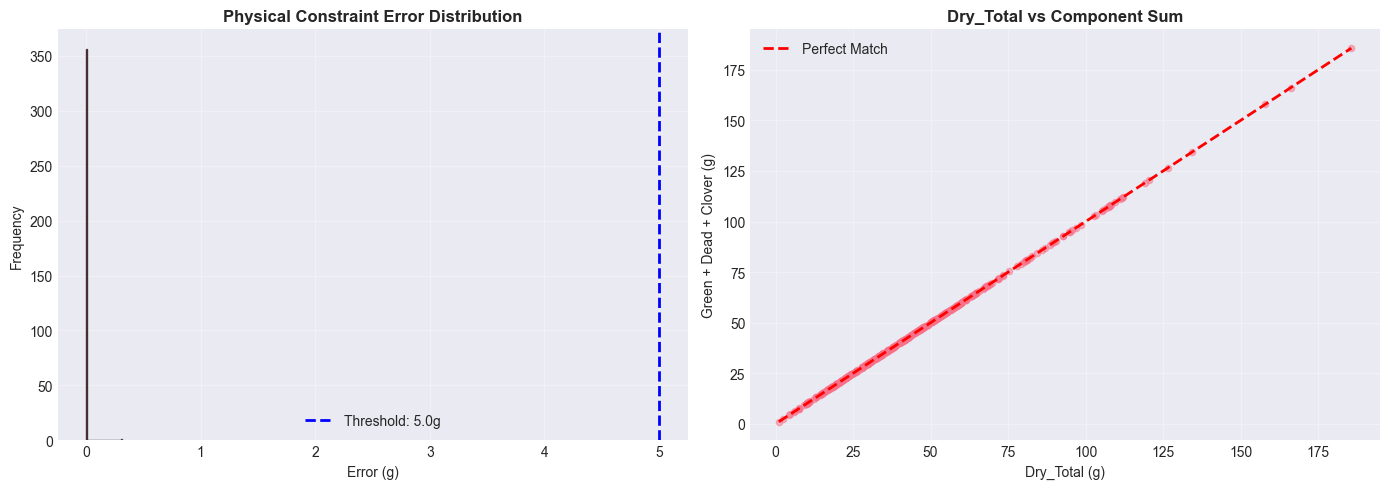

In [16]:
def check_physical_constraints(df: pd.DataFrame, threshold: float = 5.0) -> None:
    """Check and visualize physical constraint violations"""
    
    violations = df[df['constraint_error'] > threshold]
    
    print("\n" + "="*80)
    print("PHYSICAL CONSTRAINT CHECK")
    print("="*80)
    print(f"\nConstraint: Dry_Total ≈ Dry_Green + Dry_Dead + Dry_Clover")
    print(f"Threshold: {threshold}g")
    print(f"Violations: {len(violations):,} / {len(df):,} ({len(violations)/len(df)*100:.1f}%)")
    
    print(f"\nConstraint Error Statistics:")
    print(df['constraint_error'].describe())
    
    if len(violations) > 0:
        print(f"\nTop 10 Violations:")
        top_viol = violations.nlargest(10, 'constraint_error')[[
            'image_id', 'Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 
            'Dry_Clover_g', 'sum_components', 'constraint_error'
        ]]
        print(top_viol.to_string(index=False))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Error distribution
    axes[0].hist(df['constraint_error'], bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[0].axvline(threshold, color='blue', linestyle='--', linewidth=2, 
                   label=f'Threshold: {threshold}g')
    axes[0].set_title('Physical Constraint Error Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Error (g)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dry_Total vs sum_components
    axes[1].scatter(df['Dry_Total_g'], df['sum_components'], alpha=0.5, s=20)
    axes[1].plot([df['Dry_Total_g'].min(), df['Dry_Total_g'].max()],
                [df['Dry_Total_g'].min(), df['Dry_Total_g'].max()],
                'r--', linewidth=2, label='Perfect Match')
    axes[1].set_title('Dry_Total vs Component Sum', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Dry_Total (g)')
    axes[1].set_ylabel('Green + Dead + Clover (g)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

check_physical_constraints(df)

## Outlier Detection

We'll use two methods:
1. **IQR Method**: Q1 - 1.5×IQR to Q3 + 1.5×IQR
2. **Z-Score Method**: |Z| > 3.0


Outlier Detection: Dry_Green_g

【IQR Method】
Bounds: [-30.63g, 74.51g]
Outliers: 20 (5.6%)

【Z-Score Method】(threshold=3.0)
Mean: 26.62g, Std: 25.40g
Outliers: 10 (2.8%)


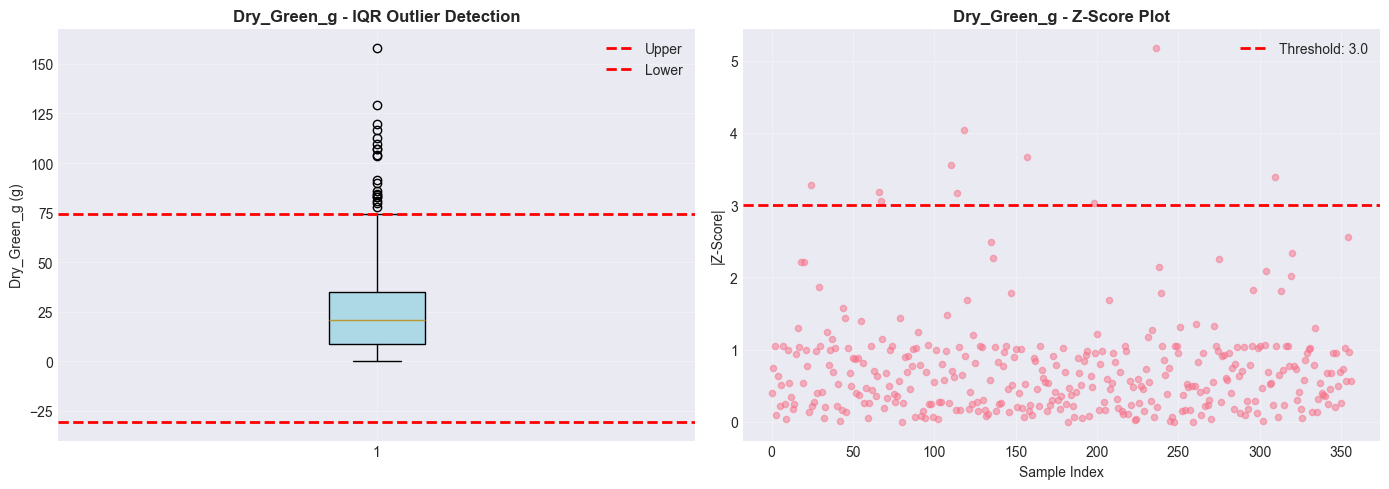


Outlier Detection: Dry_Dead_g

【IQR Method】
Bounds: [-18.46g, 39.29g]
Outliers: 14 (3.9%)

【Z-Score Method】(threshold=3.0)
Mean: 12.04g, Std: 12.40g
Outliers: 6 (1.7%)


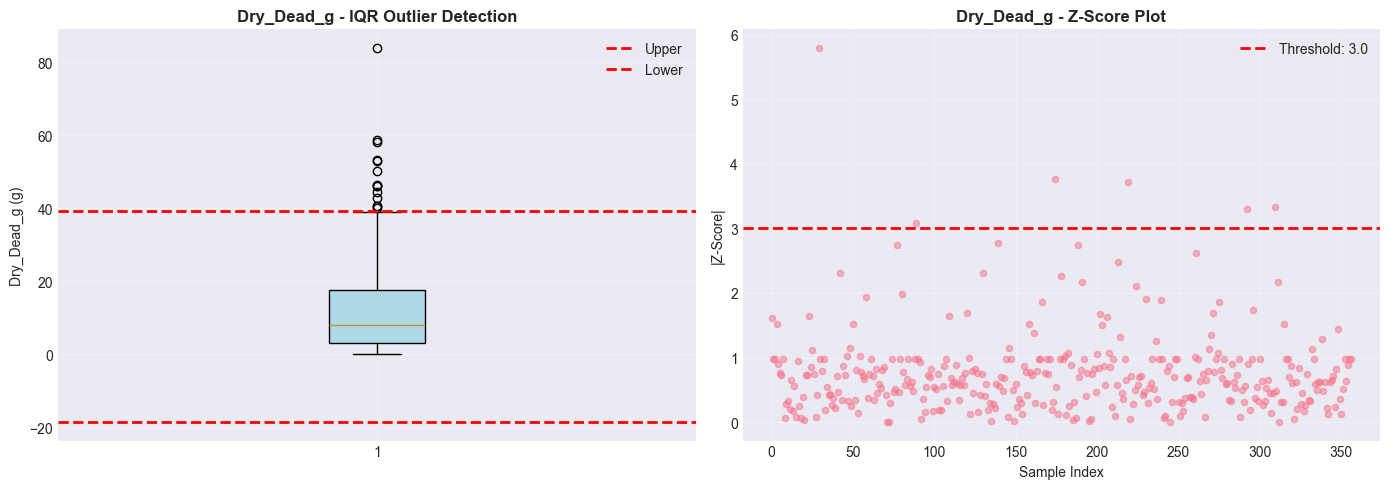


Outlier Detection: Dry_Clover_g

【IQR Method】
Bounds: [-10.86g, 18.11g]
Outliers: 41 (11.5%)

【Z-Score Method】(threshold=3.0)
Mean: 6.65g, Std: 12.12g
Outliers: 11 (3.1%)


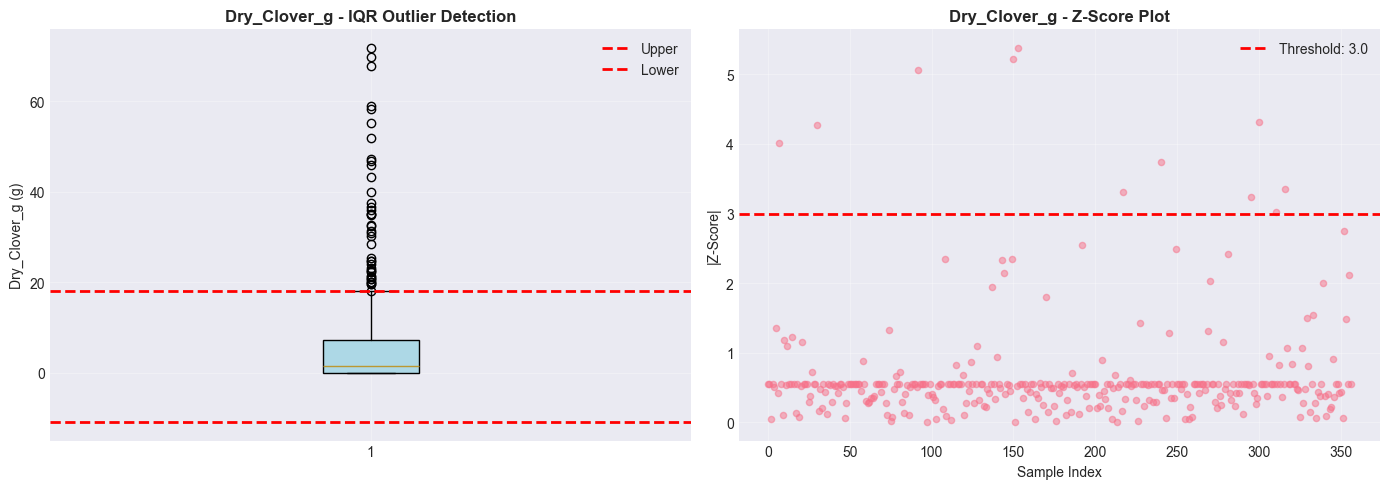


Outlier Detection: GDM_g

【IQR Method】
Bounds: [-25.45g, 85.15g]
Outliers: 16 (4.5%)

【Z-Score Method】(threshold=3.0)
Mean: 33.27g, Std: 24.94g
Outliers: 6 (1.7%)


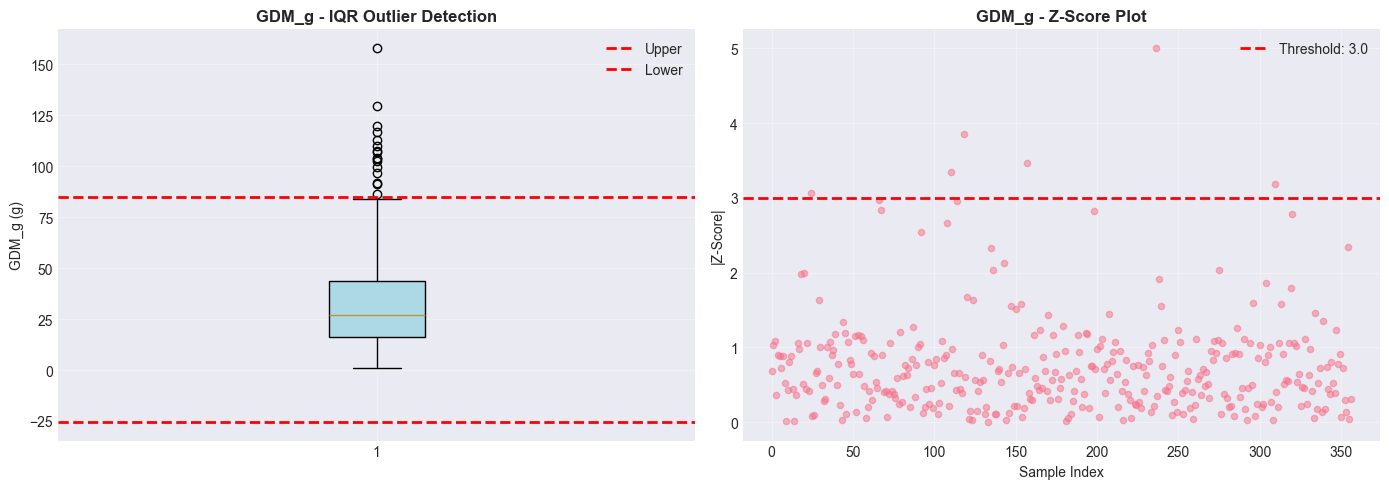


Outlier Detection: Dry_Total_g

【IQR Method】
Bounds: [-23.64g, 106.79g]
Outliers: 16 (4.5%)

【Z-Score Method】(threshold=3.0)
Mean: 45.32g, Std: 27.98g
Outliers: 4 (1.1%)


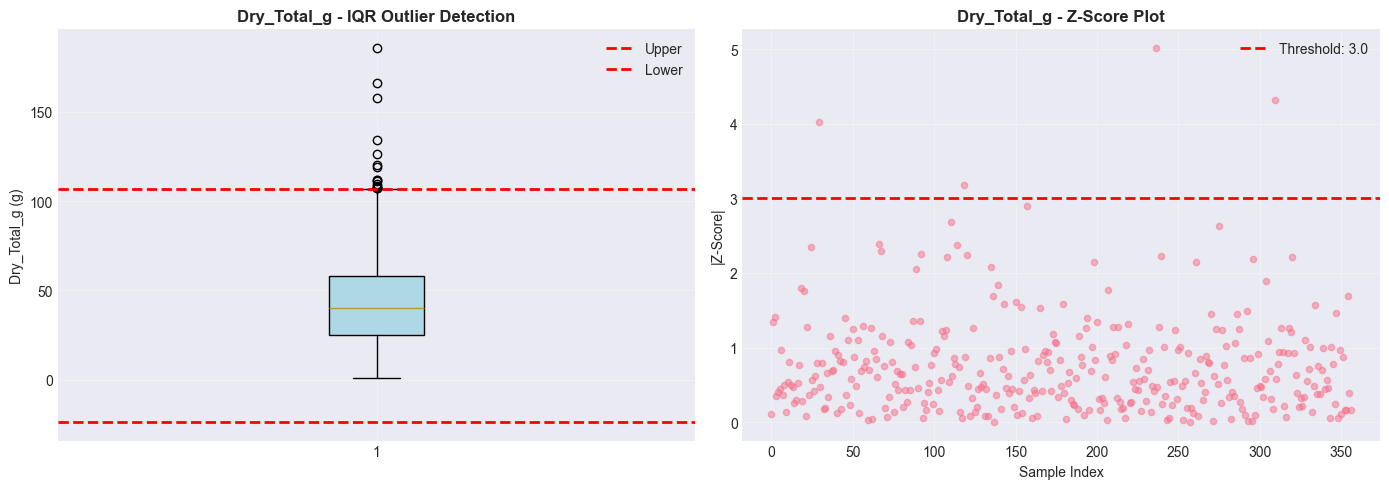

In [17]:
def detect_outliers(df: pd.DataFrame, target: str) -> dict:
    """Detect outliers using IQR and Z-score methods"""
    
    print(f"\nOutlier Detection: {target}")
    print("="*60)
    
    # IQR method
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]
    
    print(f"\n【IQR Method】")
    print(f"Bounds: [{lower_bound:.2f}g, {upper_bound:.2f}g]")
    print(f"Outliers: {len(iqr_outliers):,} ({len(iqr_outliers)/len(df)*100:.1f}%)")
    
    # Z-score method
    mean = df[target].mean()
    std = df[target].std()
    z_scores = np.abs((df[target] - mean) / std)
    zscore_outliers = df[z_scores > 3.0]
    
    print(f"\n【Z-Score Method】(threshold=3.0)")
    print(f"Mean: {mean:.2f}g, Std: {std:.2f}g")
    print(f"Outliers: {len(zscore_outliers):,} ({len(zscore_outliers)/len(df)*100:.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot
    bp = axes[0].boxplot(df[target], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[0].axhline(upper_bound, color='red', linestyle='--', linewidth=2, label='Upper')
    axes[0].axhline(lower_bound, color='red', linestyle='--', linewidth=2, label='Lower')
    axes[0].set_title(f'{target} - IQR Outlier Detection', fontsize=12, fontweight='bold')
    axes[0].set_ylabel(f'{target} (g)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Z-score plot
    axes[1].scatter(range(len(df)), z_scores, alpha=0.5, s=20)
    axes[1].axhline(3.0, color='red', linestyle='--', linewidth=2, label='Threshold: 3.0')
    axes[1].set_title(f'{target} - Z-Score Plot', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('|Z-Score|')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'iqr_outliers': iqr_outliers,
        'zscore_outliers': zscore_outliers
    }

# Detect outliers for all targets
outlier_results = {}
for target in TARGET_COLS:
    outlier_results[target] = detect_outliers(df, target)

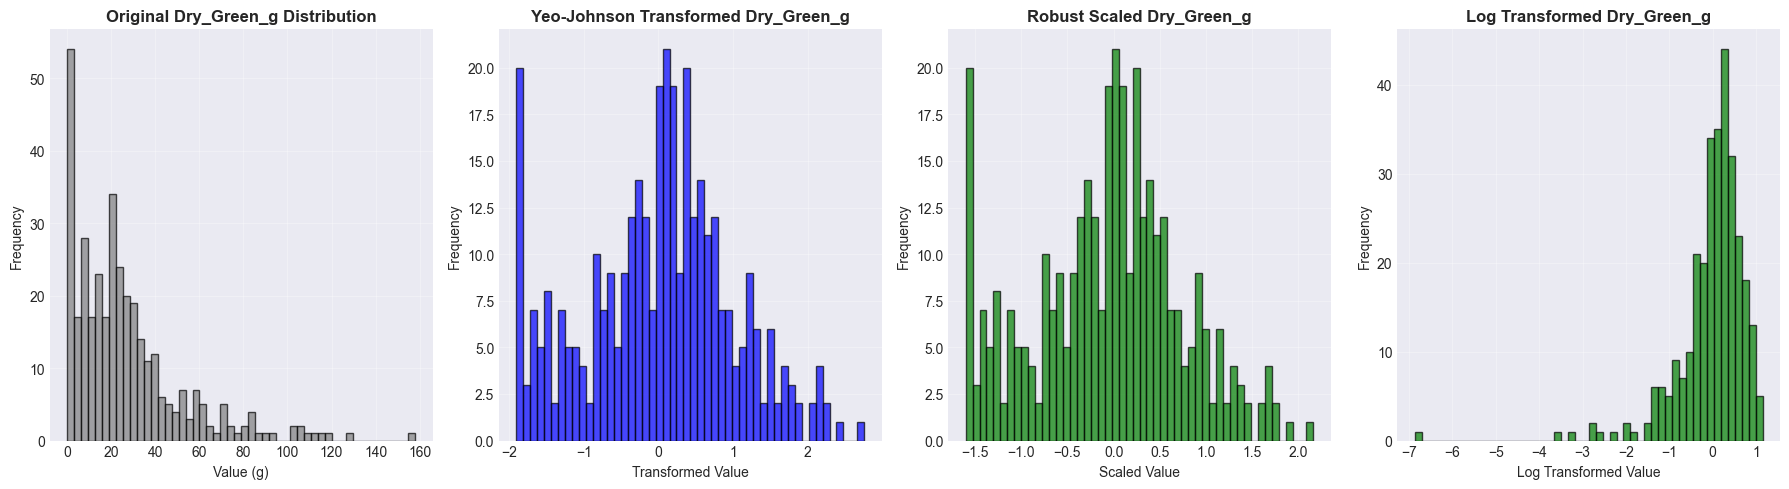

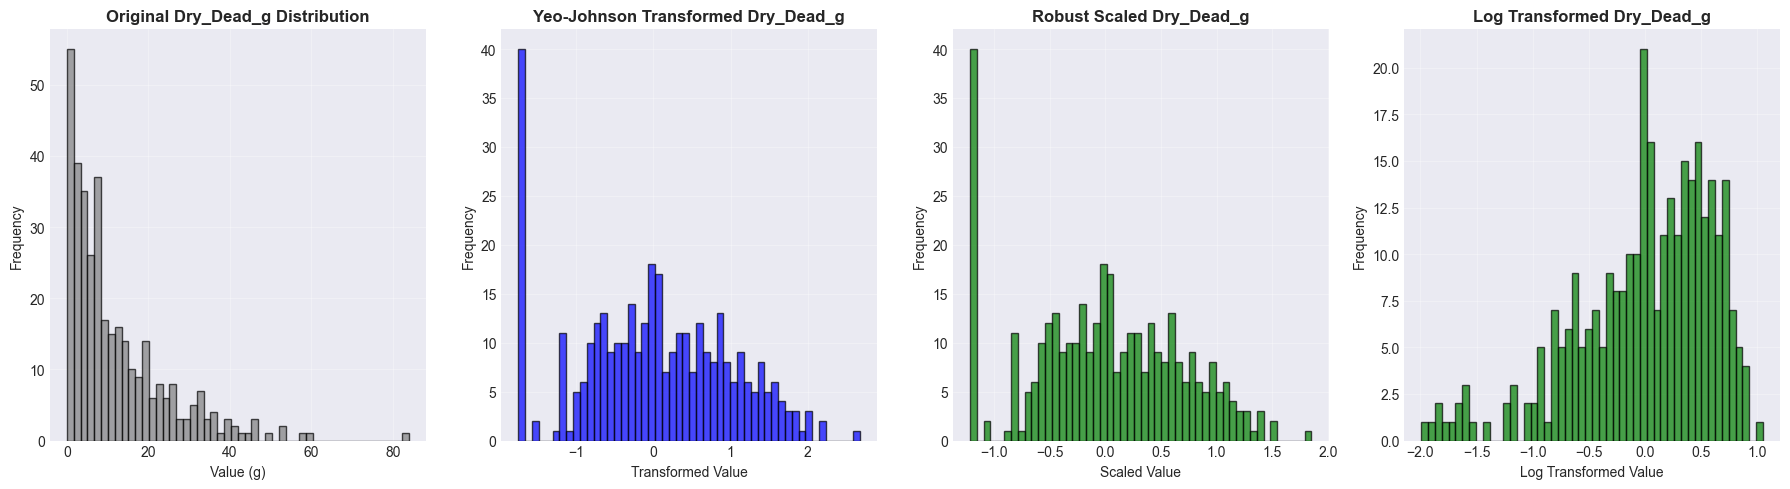

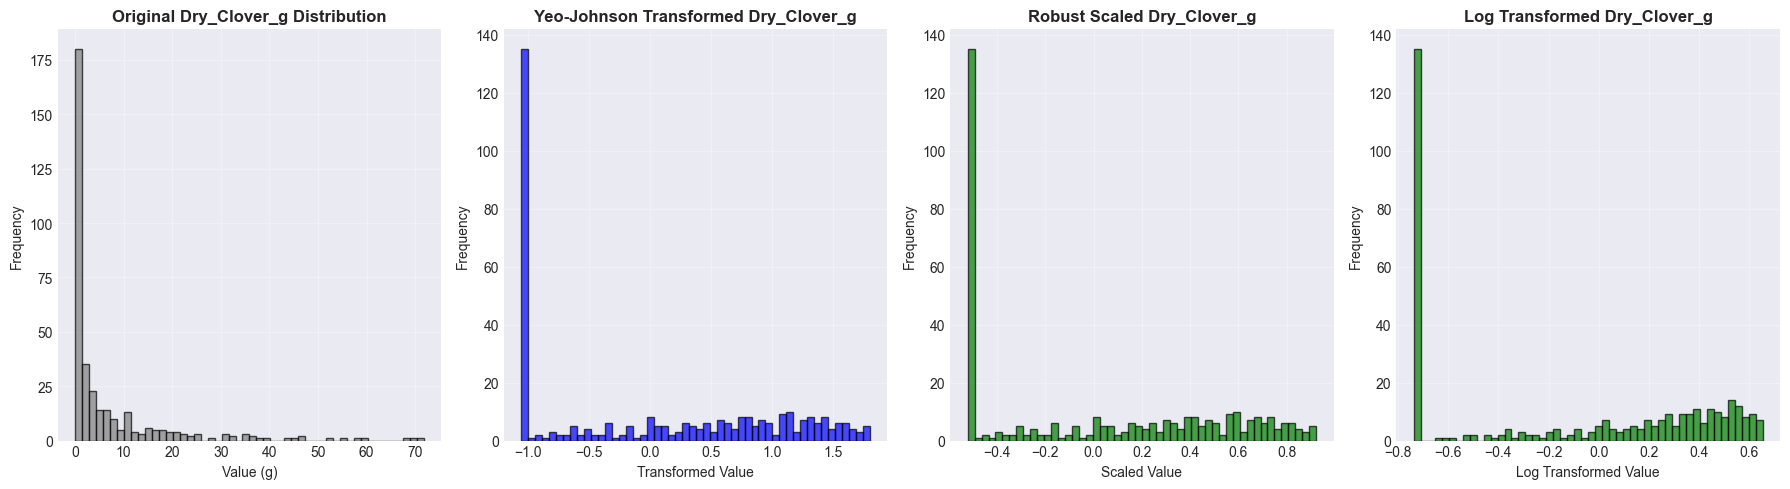

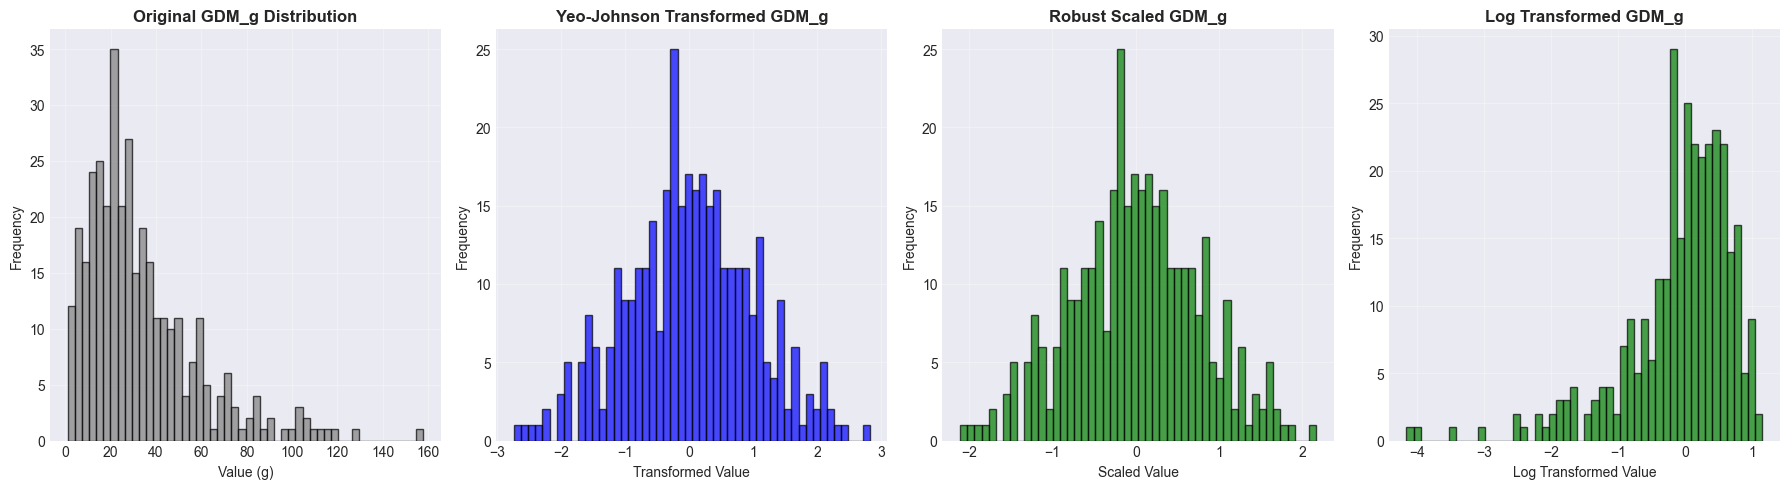

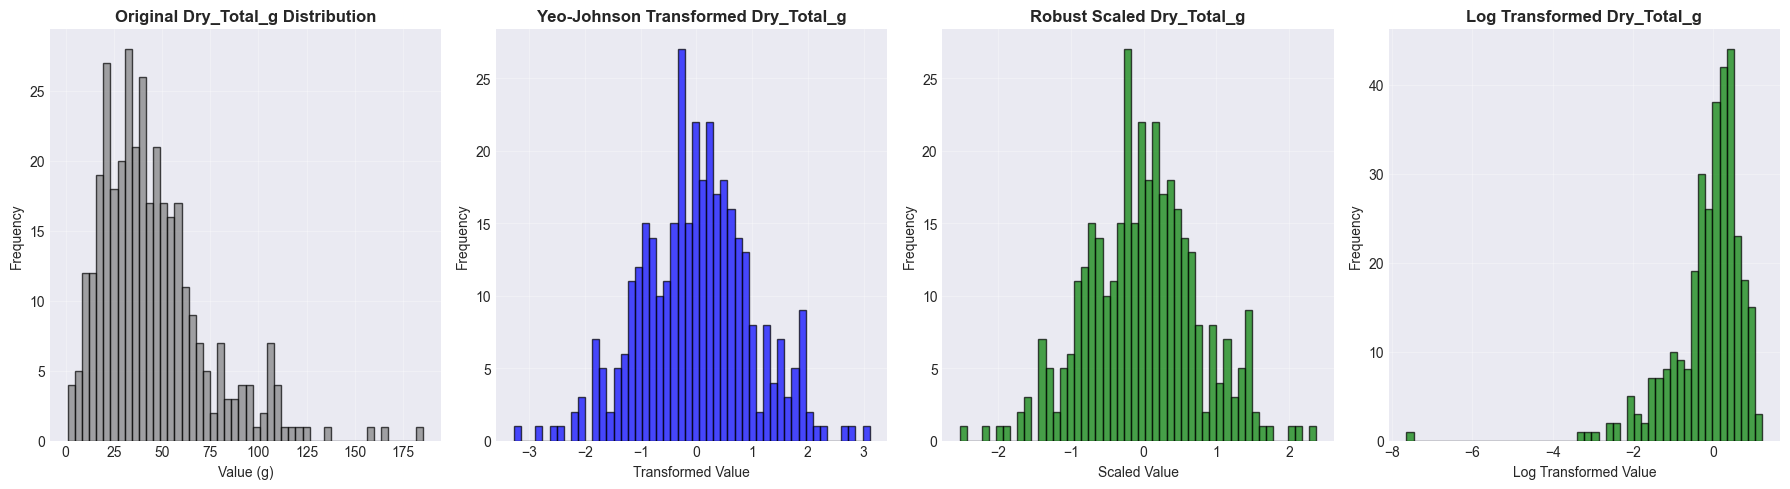

In [ ]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

def transform_and_plot(df: pd.DataFrame, target: str) -> None:
    """Apply Yeo-Johnson transformation and Robust Scaling, then plot distributions"""
    
    data = df[[target]].dropna()
    
    # Original distribution
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    axes[0].hist(data[target], bins=50, edgecolor='black', alpha=0.7, color='gray')
    axes[0].set_title(f'Original {target} Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Value (g)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    # Yeo-Johnson transformation
    pt = PowerTransformer(method='yeo-johnson')
    data_yeo = pt.fit_transform(data)
    
    axes[1].hist(data_yeo, bins=50, edgecolor='black', alpha=0.7, color='blue')
    axes[1].set_title(f'Yeo-Johnson Transformed {target}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Transformed Value')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    # Robust Scaling
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data_yeo)

    axes[2].hist(data_scaled, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[2].set_title(f'Robust Scaled {target}', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Scaled Value')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True, alpha=0.3)
    
    # Log transformation
    log = np.log1p(data_scaled)
    data_log = log

    axes[3].hist(data_log, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[3].set_title(f'Log Transformed {target}', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Log Transformed Value')
    axes[3].set_ylabel('Frequency')
    axes[3].grid(True, alpha=0.3)
     
    plt.tight_layout()
    plt.show()
# Apply to all targets
for target in TARGET_COLS:
    transform_and_plot(df, target)

This tells us that Yeo-Johnson and/or RobustScaler should be used for target normalization

## Data Characteristics:
1. **Target Distributions**
   - All targets are right-skewed
   - Consider log transformation: `log(1 + target)`
   - Outliers present in all targets

2. **Strong Correlations**
   - High correlation between related targets
   - Consider multi-task learning
   - GDM = Dry_Green + Dry_Clover (by definition)

3. **Physical Constraints**
   - Dry_Total ≈ Green + Dead + Clover
   - Can be used as regularization
   - Small violations exist (<5g for most samples)

## Metadata Patterns:
1. **Geographic Variation**
   - Different biomass levels across states
   - Consider state as categorical feature

2. **Temporal Patterns**
   - Seasonal variation exists
   - Year effects present
   - Consider temporal features

3. **Physical Measurements**
   - NDVI shows positive correlation with biomass
   - Height correlates with total biomass
   - Both are valuable features

### Potential Challenges:
1. Small dataset (357 images)
2. Class imbalance in some species
3. Outliers need handling
4. Test set may have different distribution

### Next Steps:
1. Feature engineering
2. Model selection
3. Cross-validation strategy
4. Baseline model training